In [1]:
from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp

In [2]:
!pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/8a/6a/19e9fe04fca059ccf770861c7d5721ab4c2aebc539889e97c7977528a53b/pip-24.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1


In [3]:
!pip install -q git+https://github.com/ott-jax/ott@main
#!pip install  POT
#!pip install --upgrade optax


In [4]:

x_test       = jnp.array([1.])
x_test.dtype

dtype('float64')

In [5]:
TF_CPP_MIN_LOG_LEVEL=0


import numpy as np
import numpy
import time
import timeit

from jax.example_libraries import optimizers as jax_opt



import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1
#import ot
import optax

import ott
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

from sklearn.datasets import make_blobs


In [6]:


@jax.jit
def dCdx(x, y):
  # if sqEuclidean
  # each row calculates dC_k/dx_k

  #return 2*(x-y.transpose())
  return 2 * (x[:, None, :] - y[None, :, :]) # M X N X d

@jax.jit
def dOTdx(ot):
  x = ot.geom.x
  y = ot.geom.y
  dCk_dxk =  dCdx(x,y)
  P = ot.matrix
  grad = jnp.sum(dCk_dxk * P[:,:,None], axis=1)
  return grad # M X d




@jax.jit
def LHS_matrix(ot): #
  a = ot.a # size of M
  b = ot.b # size of N
  P = ot.matrix # M by N
  a_P = jnp.sum(P, axis=1)
  b_P = jnp.sum(P, axis=0)

  a_diag = jnp.diag(a_P)  # N by N
  b_diag = jnp.diag(b_P)  # M by M
  PT     = jnp.transpose(P)

  H1 = jnp.concatenate([a_diag, P], axis = 1) # M by (M+N)
  H2 = jnp.concatenate([PT, b_diag], axis = 1) # N by (M+N)
  H = jnp.concatenate([H1, H2], axis=0) # (M+N) by (M+N)

  return H




@jax.jit
def d2Cdx2(x, y):
  # if sqEuclidean
  # the second derivative is 2
  return 2


@jax.jit
def RHS(ot):
  x = ot.geom.x
  y = ot.geom.y
  dCk_dxk =  dCdx(x,y)
  P = ot.matrix
  b_g = jnp.transpose(dCk_dxk * P[:,:,None], [1,0,2]) # N by M by d

  b_g_col = jnp.sum(b_g, axis=0) # M by D

  M, D = b_g_col.shape
  b_f  = jnp.zeros((M, M, D))
  indices = (jnp.arange(M), jnp.arange(M))
  b_f = b_f.at[indices[0], indices[1], :].set(b_g_col) # M by M by d

  b = jnp.concatenate([b_f, b_g], axis=0) # (M+N) X M X d
  return b

@jax.jit
def Sinkhorn_Hessian(ot,svd_thr=1e-10):
  epsilon = ot.geom.epsilon
  H = LHS_matrix(ot)
  nm = H.shape[0]
  R = RHS(ot)
  m = R.shape[1]

  #R_reshape = jnp.reshape(R, [nm, m*dim])
  #HdagR_reshape = jnp.linalg.lstsq(H, R_reshape, svd_thr)[0]
  #HdagR = jnp.reshape(HdagR_reshape, [nm,m,dim])
  #Hessian_1 = jnp.einsum('skd, sjt->kdjt', R, HdagR)/epsilon

  eigenvalues, eigenvectors = jnp.linalg.eigh(H)
  eigenvalues_sqrt_inv = jnp.where(eigenvalues>svd_thr, 1/jnp.sqrt(eigenvalues), 0)
  Hsqrt = eigenvectors * eigenvalues_sqrt_inv[jnp.newaxis, :] # (M+N) by r


  bHsqrt  = jnp.einsum('ikd, is ->ksd ', R, Hsqrt)  #
  Hessian_1 = jnp.einsum('ksd, jst->kdjt', bHsqrt, bHsqrt)/epsilon

  # second part
  x = ot.geom.x
  y = ot.geom.y
  P = ot.matrix
  dCk_dxk = dCdx(x, y)   # M by N by D
  d2Ck_dx2k= d2Cdx2(x, y)
  M, N, D = dCk_dxk.shape

  weighted_C = - dCk_dxk/epsilon * P[:, :, None]
  Hessian_2_part = jnp.einsum('kjs,kjt->kst', weighted_C, dCk_dxk) # M-by-D-by-D
  Hessian_3_diag = jnp.sum(d2Ck_dx2k*P,axis=1)

  identity_matrix = jnp.eye(D)
  expanded_Hessian_3_diag = Hessian_3_diag[:, None, None]
  G = Hessian_2_part + expanded_Hessian_3_diag * identity_matrix

  Hessian_2 = jnp.zeros((M, D, M, D))
  indices = jnp.arange(M)
  Hessian_2 = Hessian_2.at[indices, :, indices, :].set(G)


  Hessian = Hessian_1 + Hessian_2

  return Hessian



def sample_bolb(n, d_X, d_Y, blob_std, noise, seed):
  np.random.seed(seed)
  x, data_mem  = make_blobs(n_samples=n, n_features=d_X, centers=len(blob_std), cluster_std=blob_std)
  mu           = np.ones((n,)) / n
  nv           = np.ones((n,)) / n
  w            = np.random.normal(size=[d_X,d_Y])

  y            = x.dot(w) + noise*np.random.normal(size=[n,d_Y])
  index        = np.random.permutation(n)
  y_permute    = y[index, :]

  y_jx         = jnp.array(y_permute)
  x_jx         = jnp.array(x)
  w_jx         = jnp.array(w)

  return mu, nv, y_jx, x_jx, w_jx

In [7]:


@jax.jit
def solve_ott( y_pred, y_jx, mu, nv, 𝜀, threshold):
    geom = pointcloud.PointCloud( y_pred,y_jx, epsilon=𝜀)
    prob = linear_problem.LinearProblem(geom, a=mu, b=nv)
    solver = sinkhorn.Sinkhorn(
        threshold=threshold,  max_iterations=100000,
    )
    out = solver(prob)
    return out



@jax.jit
def loss_value(x_jx, y_jx, mu, nv, 𝜀, threshold, params):
    y_pred      = x_jx @ params
    OT          = solve_ott(y_pred,y_jx, mu, nv, 𝜀, threshold)
    value       = OT.reg_ot_cost
    return value

@jax.jit
def value_and_grad_OTT(x_jx, y_jx, mu, nv, 𝜀, threshold, params):
    y_pred      = x_jx @ params
    OT          = solve_ott(y_pred,y_jx, mu, nv, 𝜀, threshold)
    value       = OT.reg_ot_cost
    grads       = x_jx.T@dOTdx(OT)
    return value, grads, OT

@jax.jit
def value_and_grad_and_hess(x_jx, y_jx, mu, nv, 𝜀, threshold, params):
    y_pred      = x_jx @ params
    OT          = solve_ott(y_pred, y_jx, mu, nv, 𝜀, threshold)
    value       = OT.reg_ot_cost
    grads       = x_jx.T@dOTdx(OT)

    Hess        = Sinkhorn_Hessian(OT)
    x_Hess = jnp.tensordot(x_jx, Hess, axes=((0),(0)))
    hess_w = jnp.tensordot(x_Hess, x_jx,axes=((2),(0))).transpose([0,1,3,2])
    dw = jnp.linalg.tensorsolve(hess_w, grads)

    return value, grads, dw



## SGD version
@jax.jit
def value_and_grad_sgd_OTT(x_jx, y_jx, nv,  𝜀, threshold, params, indices):
    n = x_jx.shape[0]
    x = x_jx[indices]
    n_s = len(indices)
    y_pred      = x @ params
    mu          = jnp.ones((n_s,)) / n_s
    OT          = solve_ott(y_pred, y_jx, mu, nv, 𝜀, threshold)
    value       = OT.reg_ot_cost
    grads       = x.T@dOTdx(OT)
    return value, grads, OT




@jax.jit
def hess_params(OT):
    Hess             = Sinkhorn_Hessian(OT)
    x_Hess = jnp.tensordot(x_jx, Hess, axes=((0),(0)))
    hess_w = jnp.tensordot(x_Hess, x_jx,axes=((2),(0))).transpose([0,1,3,2])
    return hess_w





In [8]:
d_X        = 5
d_Y        = 2
n          = 500 #800 #1000 #100 #50
noise      = 0.2 #1 #0.2 #0.05 #0.1
𝜀          = 0.05
threshold  =  0.01 / (n**0.33)
seed       = 2 # 6 #20
blob_std   = [0.3, 0.05,0.6] # [0.5, 0.05, 1]


mu, nv, y_jx,  x_jx, w_jx = sample_bolb(n, d_X, d_Y, blob_std, noise, seed)


np.random.seed(1)
w_int        = w_jx + 1*np.random.normal(size=[d_X,d_Y])
w_int_jx     = jnp.array(w_int)
pred_jx = x_jx @ w_int_jx

In [9]:
print("We train with SGD method first.")
# setup stored
sgd_loss   = []
sgd_grads  = []
sgd_params = []

# setup parameter
num_steps_sgd          = 15 #100
sgd_learning_rate      = 0.001 #0.005
n_s                    = 100


optimizer_sgd = optax.chain(
    optax.sgd(learning_rate=sgd_learning_rate)
)

params    = w_int_jx 
params_size = jnp.size(params)
opt_state = optimizer_sgd.init(params)
values, grads, OT       = value_and_grad_OTT(x_jx, y_jx, mu, nv, 𝜀, threshold, params)
sgd_loss.append(values)
sgd_grads.append(grads)
sgd_params.append(params)
# Start training

hess_w    = hess_params(OT)
eigv      = jnp.linalg.eigvalsh(hess_w.reshape(params_size,params_size))

start_time                = time.time()
stop_counter           = 0


for i in range( num_steps_sgd):

      print(f"The loss at step {i}: {values:.4f}.")

      updates, opt_state = optimizer_sgd.update(
        grads, opt_state)

      params                  = optax.apply_updates(params, updates)
      indices = np.random.choice (n, size=(n_s,), replace=False) # SGD batch size n_s, total sample size n

      values, grads, OT       = value_and_grad_sgd_OTT(x_jx, y_jx,  mu, 𝜀, threshold, params, indices)
      sgd_loss.append(values)
      sgd_grads.append(grads)
      sgd_params.append(params)

      if (i+1)% 5 ==0:
        values, grads, OT       = value_and_grad_OTT(x_jx, y_jx, mu, nv, 𝜀, threshold, params)
        sgd_loss[-1]=values
        hess_w    = hess_params(OT)
        eigv      = jnp.linalg.eigvalsh(hess_w.reshape(params_size,params_size))
        print(f"The eigenvalues are {eigv}")
        if jnp.all(eigv > 0):
            print("All eigenvalues of Hessian for params are positive now")

            break

print(f"The final loss value is {values:.4f}.")


t1           = time.time() - start_time
print(f"Time taken for {i+1} SGD iterations: {t1:.4f} seconds.")

switch_to_newton = len(sgd_params)


We train with SGD method first.
The loss at step 0: 171.4565.
The loss at step 1: 142.2288.
The loss at step 2: 141.0361.
The loss at step 3: 107.9765.
The loss at step 4: 90.6729.
The eigenvalues are [-4.97981368e+00  6.16710824e-02  1.71017715e-01  2.77257138e-01
  3.93354334e-01  1.19311838e+01  6.58886199e+01  6.62043429e+01
  1.13217461e+02  1.13322605e+02]
The loss at step 5: 85.8281.
The loss at step 6: 80.0678.
The loss at step 7: 94.4056.
The loss at step 8: 56.2026.
The loss at step 9: 55.7254.
The eigenvalues are [8.10448528e-02 1.78894786e-01 2.79637151e-01 3.09084181e-01
 9.95997159e+00 1.20591251e+01 6.60291825e+01 6.61900082e+01
 1.13277420e+02 1.13359130e+02]
All eigenvalues of Hessian for params are positive now
The final loss value is 47.6222.
Time taken for 10 SGD iterations: 54.2329 seconds.


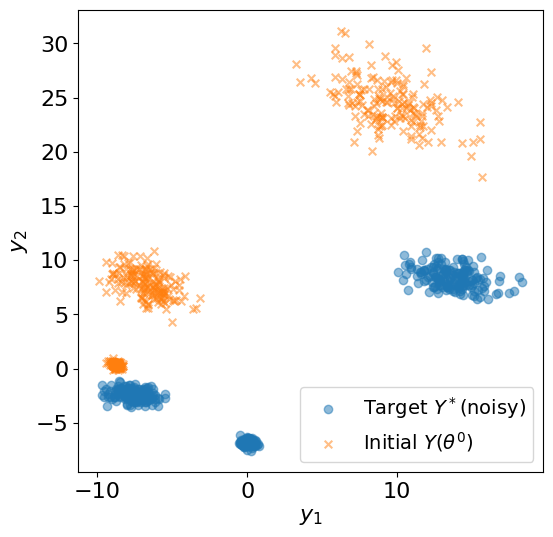

In [10]:
font = {'weight' : 'normal',
        'size'   : 16}
import matplotlib
matplotlib.rc('font', **font)
markersize = 30

fig, ax = plt.subplots(figsize=(6, 6))

plt.rcParams.update({'font.size': 16})

params = sgd_params[-1]
pred_sgd_jx      = x_jx @ params


ax.scatter(y_jx[:,0],y_jx[:,1],alpha=0.5, label=r"Target $Y^*$(noisy)")
ax.scatter(pred_jx[:,0],pred_jx[:,1],alpha=0.5, marker = "x", 
           s=markersize, label=r"Initial $Y(\theta^{0})$ ")
plt.xlabel('$y_1$')
plt.ylabel('$y_2$')
ax.legend(loc='best', fontsize=14)
plt.savefig("shuffled_regression_data_clouds.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [11]:
# setup stored
switch_to_newton = len(sgd_params)

newton_loss_ana  = []
newton_grads_ana = []
newton_params_ana =[]

# setup parameter
num_steps_newton          = 50
improvement_abs_threshold = 0.0001
Patience                  = 1
stop_counter              = 0  # Counter for consecutive iterations without sufficient improvement
newton_learning_rate      = 0.5

 

# initiate the optimizer
optimizer_newton = optax.chain(
    optax.sgd(learning_rate=newton_learning_rate),
)
params              = sgd_params[-1]
opt_state           = optimizer_newton.init(params)
newton_params_ana.append(params)


# start training
print(f"We use the current params to continue the training with Newton method after {switch_to_newton} steps SGD.")
start_time               = time.time()
for j in range(num_steps_newton):
      values, grads, dw    = value_and_grad_and_hess(x_jx, y_jx, mu, nv, 𝜀, threshold, params)


      # Compute the abs improvement
      if j > 0:  # Starting from the second iteration
        previous_values = newton_loss_ana[-1]
        abs_improvement = (previous_values - values)

        # Check if improvement is less than the threshold
        if abs_improvement < improvement_abs_threshold:
            stop_counter += 1
        else:
            stop_counter = 0  # Reset counter if there is sufficient improvement

        # Stop if there hasn't been sufficient improvement for Patience consecutive iterations
        if stop_counter >= Patience:
            print(f"Stopping early at step {j+1} due to insufficient improvement.")
            break


      newton_loss_ana.append(values)
      newton_grads_ana.append(grads)
      print(f"The loss at step {j+1}: {values:.4f}.")

      updates, opt_state = optimizer_newton.update(
        dw, opt_state, params, value=values, grad=dw, value_fn=loss_value
      )
      params               = optax.apply_updates(params, updates)


      newton_params_ana.append(params)

t2           = time.time() - start_time
print(f"Time taken for {j+1} Newton iterations: {t2:.4f} seconds")
print(f"The final loss value is {newton_loss_ana[-1]:.4f}.")


final_loss  = sgd_loss+ newton_loss_ana[1:]
final_grads = sgd_grads+newton_grads_ana[1:]
final_params= sgd_params+ newton_params_ana[1:]


We use the current params to continue the training with Newton method after 11 steps SGD.
The loss at step 1: 47.6222.
The loss at step 2: 12.5706.
The loss at step 3: 3.3627.
The loss at step 4: 1.0384.
The loss at step 5: 0.4968.
The loss at step 6: 0.3028.
The loss at step 7: 0.2520.
The loss at step 8: 0.2404.
The loss at step 9: 0.2374.
The loss at step 10: 0.2367.
The loss at step 11: 0.2365.
Stopping early at step 12 due to insufficient improvement.
Time taken for 12 Newton iterations: 2.5335 seconds
The final loss value is 0.2365.


In [ ]:
# if we always use sgd
# setup parameter
#step_to_start             = len(sgd_params)-1
abs_threshold = 0.01
newton_values = newton_loss_ana[-1]


print("We train with GD method.")
# setup stored
sgd_loss_new   = []
sgd_grads_new  = []
sgd_params_new = []

# setup parameter
num_steps_sgd          = 2000
sgd_learning_rate      = 0.001 #0.001
improvement_abs_threshold  = 0.0001
Patience               = 4
n_s                    = 500

# initiate the optimizer
optimizer_sgd = optax.chain(
    optax.sgd(learning_rate=sgd_learning_rate, momentum=0.9, nesterov=0.9),
)

params    = sgd_params[-1]
values, grads, OT       = value_and_grad_OTT(x_jx, y_jx, mu, nv, 𝜀, threshold, params)
#indices = np.random.choice (n, size=(n_s,), replace=False) # SGD batch size n_s, total sample size n
#values, grads, OT       = value_and_grad_sgd_OTT(x_jx, y_jx,  mu, 𝜀, threshold, params, indices)

sgd_loss_new.append(values)
sgd_grads_new.append(grads)

params_size = jnp.size(params)
opt_state = optimizer_sgd.init(params)
sgd_params_new.append(params)
# Start training



start_time                = time.time()

stop_counter           = 0  # Counter for consecutive iterations without sufficient improvement
opt_state              = optimizer_sgd.init(params)


for i in range( num_steps_sgd):
      if i%10==0:
          print(f"The loss at step {i}: {values:.4f}.")

      # Compute the improvement
      if i > 0:  # Starting from the second iteration
          previous_values = sgd_loss_new[-2]
          improvement = (previous_values - values)

          # Check if improvement is less than the threshold
          if improvement < improvement_abs_threshold:
              stop_counter += 1
          else:
              stop_counter = 0  # Reset counter if there is sufficient improvement

          # Stop if there hasn't been sufficient improvement for Patience consecutive iterations
          if stop_counter >= Patience:
              print(f"warm_start sgd optimizer.")
              stop_counter  = 0
              opt_state              = optimizer_sgd.init(params)


      updates, opt_state = optimizer_sgd.update(
        grads, opt_state, params, value=values, grad=grads, value_fn=loss_value
      )
      params                  = optax.apply_updates(params, updates)
    
      values, grads, OT       = value_and_grad_OTT(x_jx, y_jx, mu, nv, 𝜀, threshold, params)
      #indices = np.random.choice (n, size=(n_s,), replace=False) # SGD batch size n_s, total sample size n
      #values, grads, OT       = value_and_grad_sgd_OTT(x_jx, y_jx,  mu, 𝜀, threshold, params, indices)
    
      sgd_loss_new.append(values)
      sgd_grads_new.append(grads)
      sgd_params_new.append(params)

      if values-newton_values<abs_threshold:
        break



t3           = time.time() - start_time
print(f"The final loss value is {values:.4f}.")
print(f"Time taken for {i+1} SGD iterations: {t3:.4f} seconds")



In [28]:
# if we always use sgd
# setup parameter
#step_to_start             = len(sgd_params)-1
abs_threshold = 0.01
newton_values = newton_loss_ana[-1]


print("We train with GD method.")
# setup stored
gd_loss_new   = []
gd_grads_new  = []
gd_params_new = []

# setup parameter
num_steps_sgd          = 2000
sgd_learning_rate      = 0.001 #0.001
improvement_abs_threshold  = 0.0001
Patience               = 4
n_s                    = 500

# initiate the optimizer
optimizer_sgd = optax.chain(
    optax.sgd(learning_rate=sgd_learning_rate, momentum=0.9, nesterov=0.9),
)

params    = sgd_params[0]
values, grads, OT       = value_and_grad_OTT(x_jx, y_jx, mu, nv, 𝜀, threshold, params)
#indices = np.random.choice (n, size=(n_s,), replace=False) # SGD batch size n_s, total sample size n
#values, grads, OT       = value_and_grad_sgd_OTT(x_jx, y_jx,  mu, 𝜀, threshold, params, indices)

gd_loss_new.append(values)
gd_grads_new.append(grads)

params_size = jnp.size(params)
opt_state = optimizer_sgd.init(params)
gd_params_new.append(params)
# Start training



start_time                = time.time()

stop_counter           = 0  # Counter for consecutive iterations without sufficient improvement
opt_state              = optimizer_sgd.init(params)


for i in range( num_steps_sgd):
      if i%10==0:
          print(f"The loss at step {i}: {values:.4f}.")

      # Compute the improvement
      if i > 0:  # Starting from the second iteration
          previous_values = sgd_loss_new[-2]
          improvement = (previous_values - values)

          # Check if improvement is less than the threshold
          if improvement < improvement_abs_threshold:
              stop_counter += 1
          else:
              stop_counter = 0  # Reset counter if there is sufficient improvement

          # Stop if there hasn't been sufficient improvement for Patience consecutive iterations
          if stop_counter >= Patience:
              print(f"warm_start sgd optimizer.")
              stop_counter  = 0
              opt_state              = optimizer_sgd.init(params)


      updates, opt_state = optimizer_sgd.update(
        grads, opt_state, params, value=values, grad=grads, value_fn=loss_value
      )
      params                  = optax.apply_updates(params, updates)
    
      values, grads, OT       = value_and_grad_OTT(x_jx, y_jx, mu, nv, 𝜀, threshold, params)
      #indices = np.random.choice (n, size=(n_s,), replace=False) # SGD batch size n_s, total sample size n
      #values, grads, OT       = value_and_grad_sgd_OTT(x_jx, y_jx,  mu, 𝜀, threshold, params, indices)
    
      gd_loss_new.append(values)
      gd_grads_new.append(grads)
      gd_params_new.append(params)

      if values-newton_values<abs_threshold:
        break

print( time.time() - start_time)


We train with GD method.
The loss at step 0: 171.4565.
warm_start sgd optimizer.
warm_start sgd optimizer.
The loss at step 10: 10.9834.
warm_start sgd optimizer.
warm_start sgd optimizer.
The loss at step 20: 5.3044.
warm_start sgd optimizer.
warm_start sgd optimizer.
warm_start sgd optimizer.
The loss at step 30: 3.0571.
warm_start sgd optimizer.
warm_start sgd optimizer.
The loss at step 40: 1.8762.
warm_start sgd optimizer.
warm_start sgd optimizer.
warm_start sgd optimizer.
The loss at step 50: 1.3729.
warm_start sgd optimizer.
warm_start sgd optimizer.
The loss at step 60: 1.1035.
warm_start sgd optimizer.
warm_start sgd optimizer.
warm_start sgd optimizer.
The loss at step 70: 0.9846.
warm_start sgd optimizer.
warm_start sgd optimizer.
The loss at step 80: 0.9163.
warm_start sgd optimizer.
warm_start sgd optimizer.
warm_start sgd optimizer.
The loss at step 90: 0.8822.
warm_start sgd optimizer.
warm_start sgd optimizer.
The loss at step 100: 0.8590.
warm_start sgd optimizer.
war

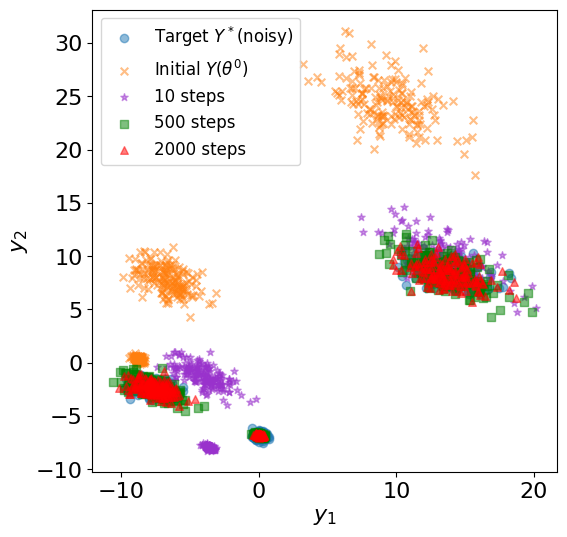

In [25]:
font = {'weight' : 'normal',
        'size'   : 16}
import matplotlib
matplotlib.rc('font', **font)
markersize = 30

fig, ax = plt.subplots(figsize=(6, 6))

plt.rcParams.update({'font.size': 16})

params = gd_params_new[10]
pred_sgd_jx      = x_jx @ params


params_gd =  gd_params_new[-1]
pred_sgd_jx_final = x_jx @ params_gd

params_gd =  gd_params_new[500]
pred_sgd_jx_500 = x_jx @ params_gd


ax.scatter(y_jx[:,0],y_jx[:,1],alpha=0.5, label=r"Target $Y^*$(noisy)")
ax.scatter(pred_jx[:,0],pred_jx[:,1],alpha=0.5, marker = "x", 
           s=markersize, label=r"Initial $Y(\theta^{0})$")


ax.scatter(pred_sgd_jx[:,0],pred_sgd_jx[:,1],alpha=0.5, marker = "*",  color = 'darkorchid',
           s=markersize, label="10 steps")

ax.scatter(pred_sgd_jx_500[:,0],pred_sgd_jx_500[:,1],alpha=0.5, marker = "s", color = 'green',
           s=markersize, label="500 steps")

ax.scatter(pred_sgd_jx_final[:,0],pred_sgd_jx_final[:,1],alpha=0.5, marker = "^", color = 'red',
           s=markersize, label="2000 steps")
ax.legend(loc='best', fontsize=12)
plt.xlabel('$y_1$')
plt.ylabel('$y_2$')
plt.savefig("shuffled_regression_gd.pdf", format="pdf", bbox_inches="tight")

plt.show()

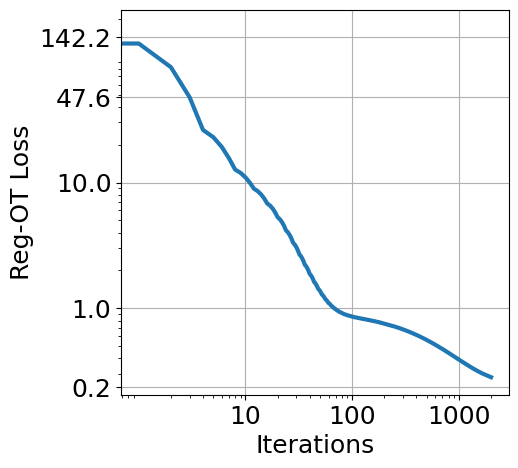

In [26]:
import matplotlib

font = {'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(5, 5))

plt.yscale('log')
plt.xscale('log')
plt.plot(np.arange(len(gd_loss_new)), gd_loss_new,lw=3)
#plt.plot(np.arange(len(sgd_params)-1, len(sgd_params)-1+len(sgd_loss_new)), sgd_loss_new, lw=3)


ax.set_xticks([len(sgd_params)-1,100, 1000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_yticks([1, 10, newton_loss_ana[-1],sgd_loss[len(sgd_params)-1],sgd_loss[1]])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.xlabel('Iterations')
plt.ylabel('Reg-OT Loss')
plt.grid()
plt.savefig("shuffled_regression_OT_loss_gd.pdf", format="pdf", bbox_inches="tight")

plt.show()

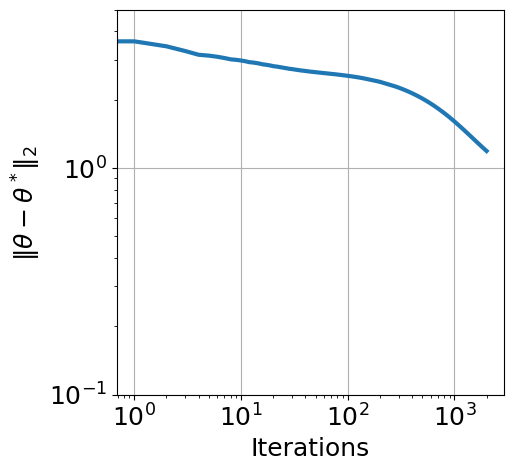

In [27]:

error_gd = []

for i in range(len(gd_params_new)):
    error_gd.append(jnp.linalg.norm(gd_params_new[i]-w_jx))
    
fig, ax2 = plt.subplots(figsize=(5, 5))

ax2.plot(np.arange(len(gd_params_new)), error_gd, label ='GD',lw=3)


ax2.set_xticks([len(sgd_params)-1,100, 1000])
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_ylim([0.1,5])
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('Iterations')
ax2.set_ylabel(r'$\|\theta-\theta^*\|_2$')
ax2.grid()
plt.savefig("shuffled_regression_error_gd.pdf", format="pdf", bbox_inches="tight")

plt.show()

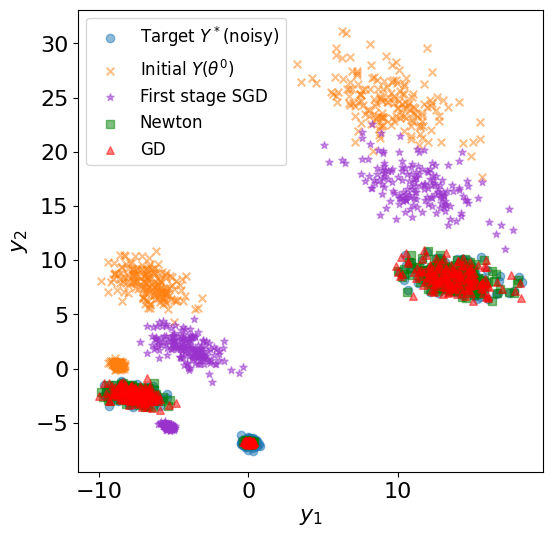

In [13]:
font = {'weight' : 'normal',
        'size'   : 16}
import matplotlib
matplotlib.rc('font', **font)
markersize = 30

fig, ax = plt.subplots(figsize=(6, 6))

plt.rcParams.update({'font.size': 16})

params = sgd_params[-1]
pred_sgd_jx      = x_jx @ params

params_newton = newton_params_ana[-1]
pred_newton_jx      = x_jx @ params_newton


params_sgd =  sgd_params_new[-1]
pred_sgd_jx_final = x_jx @ params_sgd

ax.scatter(y_jx[:,0],y_jx[:,1],alpha=0.5, label=r"Target $Y^*$(noisy)")
ax.scatter(pred_jx[:,0],pred_jx[:,1],alpha=0.5, marker = "x", 
           s=markersize, label=r"Initial $Y(\theta^{0})$")


ax.scatter(pred_sgd_jx[:,0],pred_sgd_jx[:,1],alpha=0.5, marker = "*",  color = 'darkorchid',
           s=markersize, label="First stage SGD")

ax.scatter(pred_newton_jx[:,0],pred_newton_jx[:,1],alpha=0.5, marker = "s",  color = 'green',
           s=markersize, label="Newton")

ax.scatter(pred_sgd_jx_final[:,0],pred_sgd_jx_final[:,1],alpha=0.5, marker = "^", color = 'red',
           s=markersize, label="GD")
ax.legend(loc='best', fontsize=12)
plt.xlabel('$y_1$')
plt.ylabel('$y_2$')
plt.savefig("shuffled_regression_result.pdf", format="pdf", bbox_inches="tight")

plt.show()

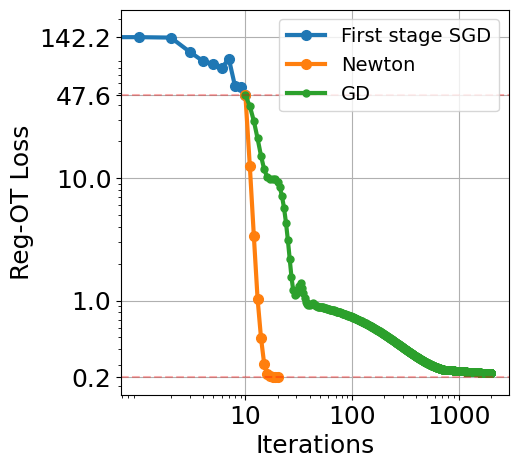

In [14]:
import matplotlib

font = {'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(5, 5))

plt.yscale('log')
plt.xscale('log')
plt.plot(np.arange(len(sgd_loss)), sgd_loss,label='First stage SGD',marker='o',lw=3,markersize=7)
plt.plot(np.arange(len(sgd_params)-1, len(sgd_params)-1+len(newton_loss_ana)),newton_loss_ana,lw=3,marker='o', markersize=7, label='Newton')
plt.plot(np.arange(len(sgd_params)-1, len(sgd_params)-1+len(sgd_loss_new)), sgd_loss_new, lw=3,marker='o',markersize=5,label ='GD')

plt.axhline(y =newton_loss_ana[-1] , color = 'r', alpha=0.3,linestyle = '--') 
plt.axhline(y =sgd_loss[len(sgd_params)-1] , color = 'r', alpha=0.3,linestyle = '--') 

ax.set_xticks([len(sgd_params)-1,100, 1000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_yticks([1, 10, newton_loss_ana[-1],sgd_loss[len(sgd_params)-1],sgd_loss[1]])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.xlabel('Iterations')
plt.ylabel('Reg-OT Loss')
plt.grid()
plt.legend(fontsize=14)
plt.savefig("shuffled_regression_OT_loss.pdf", format="pdf", bbox_inches="tight")

plt.show()

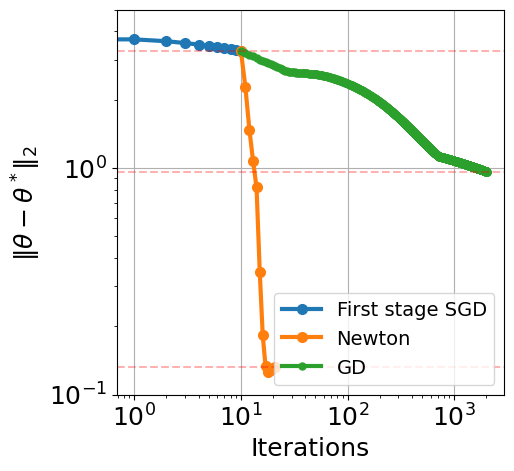

In [15]:
error_sgd = []
error_newton = []
error_gd = []
for i in range(len(sgd_params)):
    error_sgd.append(jnp.linalg.norm(sgd_params[i]-w_jx))
    
for i in range(len(newton_params_ana)):
    error_newton.append(jnp.linalg.norm(newton_params_ana[i]-w_jx))

for i in range(len(sgd_params_new)):
    error_gd.append(jnp.linalg.norm(sgd_params_new[i]-w_jx))
    
fig, ax2 = plt.subplots(figsize=(5, 5))
ax2.plot(np.arange(len(sgd_loss)), error_sgd,label='First stage SGD',marker='o',lw=3,markersize=7)
ax2.plot(np.arange(len(sgd_params)-1, len(sgd_params)-1+len(newton_params_ana)), error_newton,label='Newton',marker='o',lw=3,markersize=7)
ax2.plot(np.arange(len(sgd_params)-1, len(sgd_params)-1+len(sgd_params_new)), error_gd, label ='GD',marker='o',lw=3,markersize=5)

ax2.axhline(y =error_newton[-1] , color = 'r', alpha=0.3,linestyle = '--') 
ax2.axhline(y =error_sgd[-1] , color = 'r', alpha=0.3,linestyle = '--') 
ax2.axhline(y =error_gd[-1] , color = 'r', alpha=0.3,linestyle = '--') 

ax2.set_xticks([len(sgd_params)-1,100, 1000])
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_yticks([error_newton[-1],error_sgd[-1],error_gd[-1]])
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_ylim([0.1,5])
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('Iterations')
ax2.set_ylabel(r'$\|\theta-\theta^*\|_2$')
ax2.grid()
ax2.legend(fontsize=14)
plt.savefig("shuffled_regression_error.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [24]:
params = newton_params_ana[-1]
values, grads, OT       = value_and_grad_OTT(x_jx, y_jx, mu, nv, 𝜀, threshold, params)
hess_w    = hess_params(OT)
eigv      = jnp.linalg.eigvalsh(hess_w.reshape(params_size,params_size))
print(eigv)

[8.60166126e-02 9.57513809e-02 2.32529956e-01 2.57226406e-01
 1.20415992e+01 1.20624635e+01 6.61313705e+01 6.61927324e+01
 1.13290590e+02 1.13335909e+02]
